<a href="https://colab.research.google.com/github/NatBrian/mediapipe-hand-recognition/blob/main/notebooks/keypoint_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keypoint Classification

## 1. Project Overview

In this project, we build a machine learning model to classify **hand gestures** from **21 hand keypoints** extracted using **Mediapipe Hands**.

Each sample in our dataset is:
- One frame containing a hand gesture,
- Represented by 21 2D landmarks = 42 numeric features (x,y for each landmark),
- Labeled with a discrete gesture class (0–n).


In [2]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.1


## 2. Dataset Loading and Basic Understanding

We assume the dataset has been collected earlier using Mediapipe Hands and saved to a CSV file.

**CSV format assumption:**

Each row corresponds to **one gesture sample**:

- Column 0: integer gesture label (0, 1, 2, 3).
- Columns 1–42: 21 hand landmarks × (x, y) coordinates:
  \[
  [x_1, y_1, x_2, y_2, \dots, x_{21}, y_{21}]
  \]

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

dataset = '../data/keypoint.csv'
model_save_path = f'../models/keypoint/keypoint_classifier_{timestamp}.keras'
tflite_save_path = f'../models/keypoint/keypoint_classifier_{timestamp}.tflite'

# NUM_CLASSES number of gesture classes automatically set below 
NUM_LANDMARKS = 21
FEATURES_PER_LANDMARK = 2  # x and y
INPUT_DIM = NUM_LANDMARKS * FEATURES_PER_LANDMARK


In [ ]:
# Load features (columns 1..42)
X_dataset = np.loadtxt(
    dataset,
    delimiter=',',
    dtype='float32',
    usecols=list(range(1, INPUT_DIM + 1))
)

# Load labels (column 0)
y_dataset = np.loadtxt(
    dataset,
    delimiter=',',
    dtype='int32',
    usecols=(0,)
)

# Classification settings
labels = np.unique(y_dataset)
NUM_CLASSES = len(labels) # number of gesture classes
print("Gesture classes:", labels)
print("NUM_CLASSES:", NUM_CLASSES)

print("X_dataset shape:", X_dataset.shape)  # (N, 42)
print("y_dataset shape:", y_dataset.shape)  # (N,)
print("First 3 samples (features):")
print(X_dataset[:3])
print("First 3 labels:", y_dataset[:3])


X_dataset shape: (1267, 42)
y_dataset shape: (1267,)
First 3 samples (features):
[[ 0.          0.         -0.4019608  -0.14705883 -0.6862745  -0.33333334
  -0.872549   -0.48039216 -1.         -0.5980392  -0.27450982 -0.50980395
  -0.30392158 -0.6960784  -0.29411766 -0.8137255  -0.25490198 -0.9313725
   0.         -0.50980395  0.0882353  -0.6764706   0.15686275 -0.8039216
   0.24509804 -0.9117647   0.23529412 -0.47058824  0.37254903 -0.6372549
   0.4509804  -0.75490195  0.5392157  -0.8627451   0.42156863 -0.4019608
   0.5980392  -0.51960784  0.71568626 -0.5686275   0.8137255  -0.61764705]
 [ 0.          0.         -0.4117647  -0.13725491 -0.6960784  -0.32352942
  -0.872549   -0.46078432 -1.         -0.57843137 -0.25490198 -0.49019608
  -0.30392158 -0.6862745  -0.30392158 -0.8039216  -0.27450982 -0.9313725
   0.01960784 -0.5         0.09803922 -0.6764706   0.15686275 -0.8039216
   0.24509804 -0.9019608   0.24509804 -0.47058824  0.39215687 -0.627451
   0.46078432 -0.74509805  0.54901963 

### 2.1 Interpreting the Data

From the shapes:

- `X_dataset` has shape `(N, 42)`:
  - `N` = number of samples (gesture instances),
  - `42` = 21 keypoints × 2 coordinates (x,y).
- `y_dataset` has shape `(N,)` with integer labels `0, 1, 2, 3`.

For clarity in the report, we can map labels to gesture names.  
Example (adjust to your dataset):

- 0 → Fist  
- 1 → Open hand  
- 2 → Pointing  
- 3 → Victory Pose

This mapping will be used when discussing confusion matrices and results.


Label distribution:
Class 0: 200 samples
Class 1: 190 samples
Class 2: 204 samples
Class 3: 213 samples
Class 4: 239 samples
Class 5: 221 samples


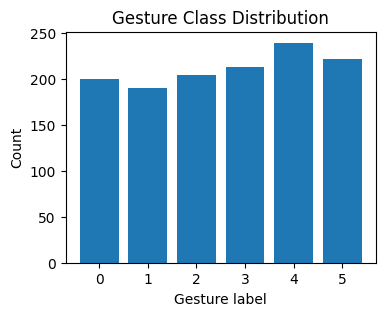

In [5]:
# Compute unique labels and counts using NumPy
labels, counts = np.unique(y_dataset, return_counts=True)

print("Label distribution:")
for label, count in zip(labels, counts):
    print(f"Class {label}: {count} samples")

# Simple bar plot of label distribution
plt.figure(figsize=(4, 3))
plt.bar(labels, counts)
plt.xticks(labels)
plt.xlabel("Gesture label")
plt.ylabel("Count")
plt.title("Gesture Class Distribution")
plt.show()


### 2.2 Visualising a Hand Sample

Visualise one sample as a 2D hand skeleton to:

- Check that the coordinates look reasonable,
- Connect the numeric features back to the actual hand pose.

Below, we reshape a single feature vector `(42,)` into `(21, 2)` and plot the 21 (x,y) points.


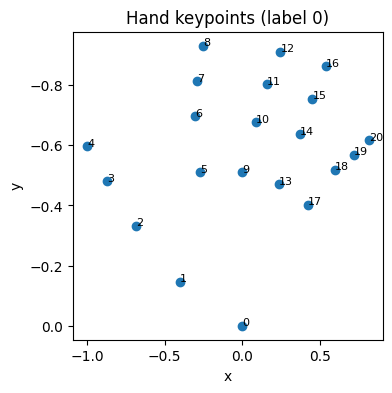

In [6]:
def plot_hand_keypoints(sample, title="Example hand keypoints"):
    """
    sample: numpy array of shape (42,) with [x1, y1, x2, y2, ..., x21, y21]
    """
    assert sample.shape == (INPUT_DIM,)

    points = sample.reshape(NUM_LANDMARKS, FEATURES_PER_LANDMARK)
    xs = points[:, 0]
    ys = points[:, 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(xs, ys)
    # Optionally connect points in some fixed order (not critical for this project)
    for i, (x, y) in enumerate(zip(xs, ys)):
        plt.text(x, y, str(i), fontsize=8)
    plt.gca().invert_yaxis()  # often needed depending on coordinate system
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

# Plot first sample
plot_hand_keypoints(X_dataset[0], title=f"Hand keypoints (label {y_dataset[0]})")


## 3. Train/Test Split

We now split the data into **training** and **test** sets.

- **Training set**: used to fit the models (learn parameters).
- **Test set**: used as **held-out data** to estimate generalisation performance.

Because the dataset is relatively small, we use only **two splits**:

- 75% for training
- 25% for testing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dataset,
    y_dataset,
    train_size=0.75,
    random_state=RANDOM_SEED,
    stratify=y_dataset  # keep class proportions similar
)

print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Train set size: 950
Test set size: 317


## 4. Neural Network (MLP) for Gesture Classification

We now implement the **same neural network architecture**.

### 4.1 Model Architecture

The model is a **Multilayer Perceptron (MLP)**:

- **Input layer**: 42 features (21 (x,y) pairs).
- **Hidden layers**:
  - Dropout(0.2)
  - Dense(20 units, ReLU activation)
  - Dropout(0.4)
  - Dense(10 units, ReLU activation)
- **Output layer**:
  - Dense(`NUM_CLASSES`, softmax activation)

**Why this architecture?**

- Dense layers with **ReLU** non-linearity allow the model to learn complex, non-linear mappings from keypoints to gestures.
- **Dropout** randomly “turns off” neurons during training, which:
  - Acts as regularisation,
  - Helps reduce overfitting on small datasets.
- **Softmax** in the output layer:
  - Produces a probability distribution over the 4 gesture classes.
- Loss function: `sparse_categorical_crossentropy`
  - Suitable for multi-class classification with integer labels (0–3).
- Optimizer: `Adam`
  - Popular adaptive gradient-based method that usually works well “out-of-the-box”.

### 4.2 Training Strategy (Note on Train/Test Only)

We now train the neural network:

- Training data: `X_train, y_train`
- Validation data: **we reuse `X_test, y_test`**

Because the dataset is small and we only split into **train** and **test**, we do not have a separate validation set.

**Important methodological note (for the report):**

- Using the **test set as validation data** means:
  - We “peek” at test performance during training,
  - This can slightly **overestimate** true generalisation performance.
- For a production system or a larger dataset, we would normally:
  - Split into **train / validation / test**, or
  - Use cross-validation.

We explicitly acknowledge this limitation in our analysis to show awareness of best practices.


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((INPUT_DIM,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,136 (4.44 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Model checkpoint callback: saves model's weights during training
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path,
    verbose=1,
    save_weights_only=False
)

# Early stopping: stop if validation loss doesn't improve for 20 epochs
es_callback = tf.keras.callbacks.EarlyStopping(
    patience=20,
    verbose=1
)


In [11]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback],
    verbose=1
)


Epoch 1/1000
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1632 - loss: 1.8807  
Epoch 1: saving model to ../models/keypoint/keypoint_classifier_20251119_132243.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.1789 - loss: 1.8651 - val_accuracy: 0.1956 - val_loss: 1.7904
Epoch 2/1000
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1562 - loss: 1.8317
Epoch 2: saving model to ../models/keypoint/keypoint_classifier_20251119_132243.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1589 - loss: 1.8473 - val_accuracy: 0.2271 - val_loss: 1.7789
Epoch 3/1000
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2031 - loss: 1.8518
Epoch 3: saving model to ../models/keypoint/keypoint_classifier_20251119_132243.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1737 - loss: 1.8205 - val_accuracy: 0.2429 - val_loss: 1.7733
Epoch 4/1000
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1797 - loss: 1.8064
Epoch 4: saving model to ../models/keypoint/keypoint_classi

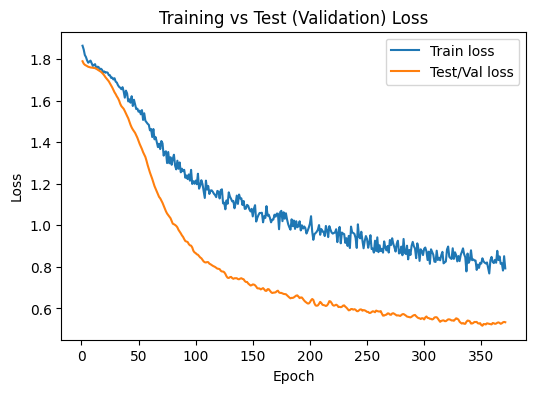

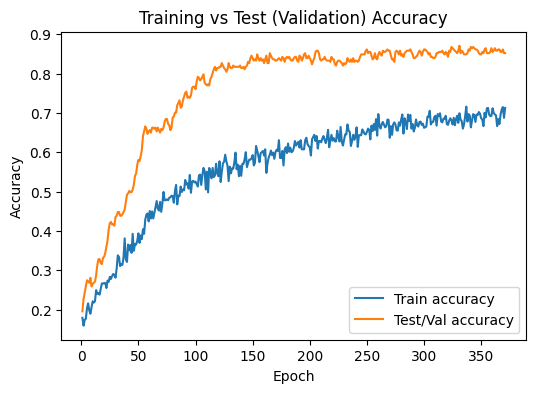

In [12]:
# Convert history.history (a dict) into simple lists
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs_ran = range(1, len(train_loss) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs_ran, train_loss, label='Train loss')
plt.plot(epochs_ran, val_loss, label='Test/Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test (Validation) Loss')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs_ran, train_acc, label='Train accuracy')
plt.plot(epochs_ran, val_acc, label='Test/Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Test (Validation) Accuracy')
plt.legend()
plt.show()


### 4.3 How to Interpret Learning Curves (Loss & Accuracy)

**1. Loss curves (training loss vs validation loss)**  
- Loss measures **how wrong** the model is; **lower loss is better**.  
- A desirable pattern is:
  - **Training loss decreases** over epochs → the model is learning patterns from the training data.
  - **Validation loss also decreases** (or stabilises at a low level) → the model is generalising to unseen data.
- If validation loss **starts increasing while training loss keeps decreasing**, this indicates **overfitting**, where the model learns the training data too specifically and fails to generalise.
- If **both losses stay high and decrease very slowly**, the model is **underfitting**, meaning it is not powerful enough or not trained long enough.

**2. Accuracy curves (training accuracy vs validation accuracy)**  
- Accuracy measures the **percentage of correct predictions**; **higher accuracy is better**.  
- A good learning process typically shows:
  - **Training accuracy increases** steadily.
  - **Validation accuracy also increases** and ideally tracks close to the training curve.
- A **large gap** where training accuracy is much higher than validation accuracy suggests **overfitting**.
- If **both accuracies remain low** despite training, the model may be **underfitting** or requires architectural/parameter adjustments.

**3. Curve shape and behaviour**  
- Early rapid improvement followed by a plateau is normal.
- Small oscillations in the curves are expected.
- The goal is to see **consistent improvement** without divergence between training and validation curves.

**4. Role of EarlyStopping**  
- EarlyStopping monitors validation loss and stops training when it stops improving.
- This helps avoid entering the overfitting region, reduces training time, and automatically preserves the best-performing model.

Together, these curves provide insight into whether the model is learning effectively, generalising well, or suffering from underfitting or overfitting.


In [13]:
# Load the best saved model from checkpoint (for safety)
best_model = tf.keras.models.load_model(model_save_path)

test_loss, test_acc = best_model.evaluate(X_test, y_test, batch_size=128, verbose=0)
print(f"Neural Network – Test loss: {test_loss:.4f}")
print(f"Neural Network – Test accuracy: {test_acc:.4f}")


Neural Network – Test loss: 0.5334
Neural Network – Test accuracy: 0.8517


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


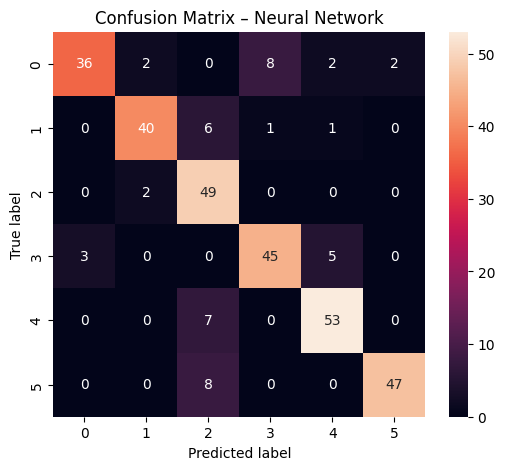

Neural Network – Test Classification Report
              precision    recall  f1-score   support

           0     0.9231    0.7200    0.8090        50
           1     0.9091    0.8333    0.8696        48
           2     0.7000    0.9608    0.8099        51
           3     0.8333    0.8491    0.8411        53
           4     0.8689    0.8833    0.8760        60
           5     0.9592    0.8545    0.9038        55

    accuracy                         0.8517       317
   macro avg     0.8656    0.8502    0.8516       317
weighted avg     0.8661    0.8517    0.8528       317



In [14]:
# Predict probabilities for all test samples
Y_pred = best_model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = sorted(np.unique(y_test))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Neural Network")
plt.show()

print("Neural Network – Test Classification Report")
print(classification_report(y_test, y_pred, digits=4))


### 4.4 Interpreting the Confusion Matrix and Classification Report

When evaluating a classification model, the **confusion matrix** and **classification report** are powerful tools to understand its performance beyond just overall accuracy.

**Confusion Matrix (Visual Overview):**
-   **Rows:** Represent the *actual* (true) classes of the samples.
-   **Columns:** Represent the *predicted* classes by the model.
-   **Diagonal Elements:** Show the number of correctly classified instances for each class (True Positives).
    -   `True Label = Predicted Label`
-   **Off-Diagonal Elements:** Show the number of misclassified instances.
    -   `True Label ≠ Predicted Label`
    -   By observing where the off-diagonal errors occur, you can identify which classes the model is confusing with each other.

**Classification Report (Detailed Metrics):**
This report provides a breakdown of several key metrics for each class, as well as macro and weighted averages:
-   **Precision:** Of all samples *predicted* as a certain class, how many actually belong to that class?
    -   `Precision = True Positives / (True Positives + False Positives)`
    -   High precision means a low false positive rate.
-   **Recall (Sensitivity):** Of all samples that *actually belong* to a certain class, how many did the model correctly identify?
    -   `Recall = True Positives / (True Positives + False Negatives)`
    -   High recall means a low false negative rate.
-   **F1-score:** The harmonic mean of precision and recall. It provides a single metric that balances both. It's especially useful when classes are imbalanced.
    -   `F1-score = 2 * (Precision * Recall) / (Precision + Recall)`
-   **Support:** The number of actual occurrences of each class in the specified dataset (e.g., the test set).
-   **Accuracy:** The proportion of correctly classified instances out of the total instances.
-   **Macro Avg:** The average of the metrics (precision, recall, f1-score) calculated for each class, *without considering class imbalance*.
-   **Weighted Avg:** The average of the metrics calculated for each class, weighted by the support (number of samples) for each class. This is more representative if classes have different numbers of samples.

## 5. Deployment with TensorFlow Lite (TFLite)

To use the trained model in a **real-time Mediapipe application**, we convert it to **TensorFlow Lite format**.

Deployment pipeline (separate Python script):

1. Open camera and read frames.
2. Use **Mediapipe Hands** to detect hand landmarks.
3. Extract 21 2D landmarks (x,y) and flatten into a `(42,)` vector.
4. Feed this vector into the `.tflite` model.
5. Interpret the output probabilities and map to gesture labels.
6. Display the recognised gesture on the camera feed.

Below, we save the Keras model (for reuse) and convert it to `.tflite`.


In [15]:
# Ensure we are converting the best model (same as used for evaluation)
best_model.save(model_save_path, include_optimizer=False)

# TFLite conversion with default optimizations (e.g., quantisation)
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

print("Saved TFLite model to:", tflite_save_path)


INFO:tensorflow:Assets written to: C:\Users\brian\AppData\Local\Temp\tmp8tozrc2p\assets


INFO:tensorflow:Assets written to: C:\Users\brian\AppData\Local\Temp\tmp8tozrc2p\assets


Saved artifact at 'C:\Users\brian\AppData\Local\Temp\tmp8tozrc2p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2442680529744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2442680529552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2442680528784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2442680530896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2442680526672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2442680528400: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved TFLite model to: ../models/keypoint/keypoint_classifier_20251119_132243.tflite


In [16]:
# Test the TFLite model on a single sample to confirm it works

interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("TFLite input details:", input_details)
print("TFLite output details:", output_details)

sample = X_test[0:1].astype(np.float32)
true_label = y_test[0]

interpreter.set_tensor(input_details[0]['index'], sample)
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

print("TFLite raw output probabilities:", np.squeeze(tflite_results))
print("TFLite predicted class:", int(np.argmax(tflite_results)))
print("True class:", int(true_label))


TFLite input details: [{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([ 1, 42]), 'shape_signature': array([-1, 42]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
TFLite output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 10, 'shape': array([1, 6]), 'shape_signature': array([-1,  6]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
TFLite raw output probabilities: [2.9802698e-01 3.7156034e-03 1.7051940e-07 6.9528317e-01 2.9670629e-03
 7.0094047e-06]
TFLite predicted class: 3
True class: 0


c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
